In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from google.colab import drive

#mount drive
drive.mount('/content/drive')

#change directory
current_directory=os.getcwd()
os.chdir(current_directory)

Mounted at /content/drive


In [2]:
#available windows
windows=[10, 60, 180, 600]

TCP_FILE_NAME='data_tcp'
UDP_FILE_NAME='data_udp'
ICMP_FILE_NAME='data_icmp'

#features
feature1 = 'ts'
feature2 = 'src_ip'
feature3 = 'src_port'
feature4 = 'dst_ip'
feature5 = 'dst_port'
feature6 = 'pck_len'
feature7 = 'tcp_flags'
feature8 = 'cluster'
feature9 = 'user'
feature10 = 'num_attack'
feature11 = 'first_port_scan'
feature12 = 'ip_diff'
feature13 = 'port_diff'
feature14 = 'range_ip'
feature15 = 'range_port'
feature16 = 'ip_medium'
feature17 = 'ip_std'
feature18 = 'port_medium'
feature19 = 'port_std'
feature20 = 'pck_medium'
feature21 = 'pck_std'

In [21]:
def choose_window(proto):
  print("Choose a time window for", proto)

  user_input=False
  while not (user_input):
    for j in range(0, len(windows)):
      print(str(j+1)+") "+str(windows[j]))

    try:
      user_input = int(input(""))

      if user_input >=1 and user_input <= len(windows):
        window_chosen=windows[user_input-1]
      else:
        print ("\nChoose Well\n")
        user_input=False

    except ValueError:
      print('\nInvalid number!\n')

  return window_chosen

#read data 
def read_data(fname):
  stream = os.popen("find . -name '%s'" % fname)
  fpath = stream.read()[:-1]
  data_original= pd.read_csv(fpath)

  return data_original


#set optimal cluster parameters
class Cluster_parameters:
    def __init__(self, num_cluster, threshold, branching_factor):
        self.num_cluster = num_cluster
        self.threshold = threshold
        self.branching_factor = branching_factor


#display created clusters
def print_clusters(df, labels, num_cluster=10, title=''):
  pca = PCA(n_components=2)
  principalComponents = pca.fit_transform(df)
  principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
  labels_df = pd.DataFrame(labels, columns=['cluster']) 
  final_df = pd.concat([principalDf, labels_df[['cluster']]], axis = 1)
  final_df.dropna(inplace=True)
  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(1,1,1) 
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title(title, fontsize = 20)
  targets = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
  colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'darkorange', 'darkblue', 'pink']
  i=1
  for target, color in zip(targets,colors):
      indicesToKeep = final_df['cluster'] == target
      ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
                , final_df.loc[indicesToKeep, 'principal component 2']
                , c = color
                , s = 50)
      i=i+1
      if i>num_cluster:
        break
  ax.legend(targets)
  ax.grid()
  

# calculate clusters
def cluster(df, features, _n_clusters=4, _threshold=0.5, _branching_factor=50):
  #rescaling dataset and setting feature
  df_rescaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)

  #clusters creation with BIRCH
  brc = Birch(n_clusters=_n_clusters, threshold=_threshold, branching_factor=_branching_factor)

  labels = brc.fit_predict(df_rescaled[features])
  #label assignment 
  df_rescaled['cluster'] = labels

  #calculate clusters' size
  detail = df_rescaled.groupby(['cluster']).size()

  return df_rescaled, labels, detail

# TCP Cluster

In [5]:
#choose time window
tcp_window=choose_window("TCP")

#set file name 
file_tcp=TCP_FILE_NAME+"_"+str(tcp_window)+".csv"

#read data 
data_tcp_original=read_data(file_tcp)

#drop duplicates
data_tcp_rm = data_tcp_original.drop_duplicates(subset=['user'])

Choose a time window for TCP
1) 10
2) 60
3) 180
4) 600
4


In [112]:
tcp_parameters={}

#set parameters 
tcp_parameters[10]=Cluster_parameters(2, 0.95, 3)
tcp_parameters[60]=Cluster_parameters(2, 0.1, 50)
tcp_parameters[180]=Cluster_parameters(4, 0.4, 50)
tcp_parameters[600]=Cluster_parameters(4, 0.35, 50)

In [113]:
#features for clustering
tcp_features=[feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21]

if tcp_window in tcp_parameters.keys():
  actual_param=tcp_parameters[tcp_window]
  rescaled_data_tcp_rm, tcp_labels, detail=cluster(data_tcp_rm, tcp_features, actual_param.num_cluster, actual_param.threshold, actual_param.branching_factor)
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  rescaled_data_tcp_rm, tcp_labels, detail=cluster(data_tcp_rm, tcp_features)

print("TCP cluster's details\n", detail)

TCP cluster's details
 cluster
0    25490
1       72
2      118
3       59
dtype: int64



*Performance* 



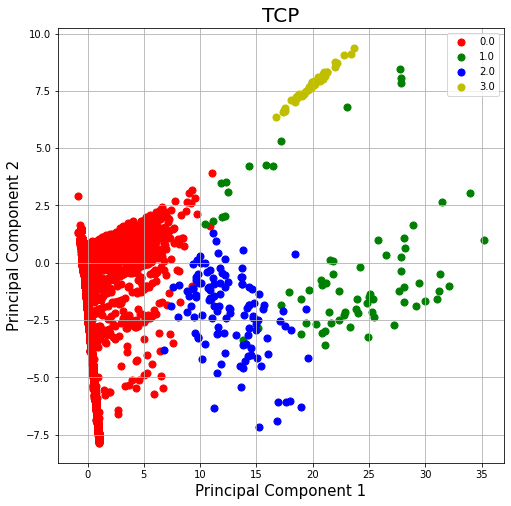

In [114]:
#print clusters
if tcp_window in tcp_parameters.keys():
  actual_param=tcp_parameters[tcp_window]
  print_clusters(rescaled_data_tcp_rm[tcp_features], tcp_labels, actual_param.num_cluster, "TCP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(rescaled_data_tcp_rm[tcp_features], tcp_labels)

In [115]:
score_tcp = silhouette_score(rescaled_data_tcp_rm[tcp_features],tcp_labels)
print(score_tcp)

0.8390562700842124


# UDP Cluster

In [13]:
#choose time window
udp_window=choose_window("UDP")

#set file name 
file_udp=UDP_FILE_NAME+"_"+str(udp_window)+".csv"

#read data 
data_udp_original=read_data(file_udp)

#drop duplicates
data_udp_rm = data_udp_original.drop_duplicates(subset=['user'])

Choose a time window for UDP
1) 10
2) 60
3) 180
4) 600
2


In [14]:
udp_parameters={}

#set parameters 
udp_parameters[10]=Cluster_parameters(4, 0.5, 50)  
udp_parameters[60]=Cluster_parameters(4, 0.7, 50)  
udp_parameters[180]=Cluster_parameters(4, 0.1, 50)
udp_parameters[600]=Cluster_parameters(3, 0.1, 50)

In [40]:
#features for clustering
udp_features=[feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21]

if udp_window in udp_parameters.keys():
  actual_param=udp_parameters[udp_window]
  rescaled_data_udp_rm, udp_labels, detail=cluster(data_udp_rm, udp_features, actual_param.num_cluster, actual_param.threshold, actual_param.branching_factor)
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  rescaled_data_udp_rm, udp_labels, detail=cluster(data_udp_rm, udp_features)

print("UDP cluster's details\n", detail)

UDP cluster's details
 cluster
0      29
1       8
2    3718
3      36
dtype: int64


*Performance*

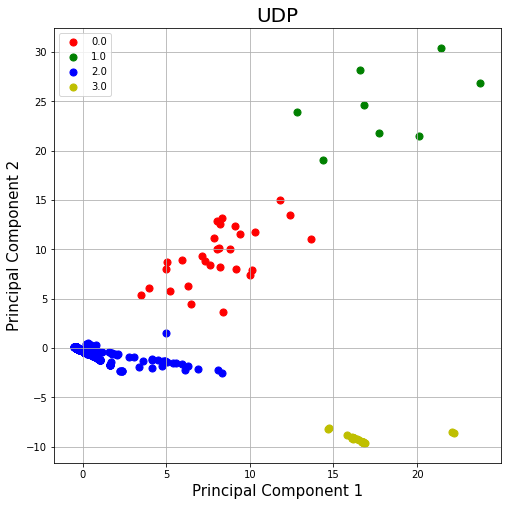

In [ ]:
#print clusters
if udp_window in udp_parameters.keys():
  actual_param=udp_parameters[udp_window]
  print_clusters(rescaled_data_udp_rm[udp_features], udp_labels, actual_param.num_cluster, "UDP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(rescaled_data_udp_rm[udp_features], udp_labels)

In [ ]:
score_udp = silhouette_score(rescaled_data_udp_rm[udp_features],udp_labels)
print(score_udp)

0.8536175627163128


# ICMP Cluster

In [17]:
#choose time window
icmp_window=choose_window("ICMP")

#set file name 
file_icmp=ICMP_FILE_NAME+"_"+str(icmp_window)+".csv"

#read data 
data_icmp_original=read_data(file_icmp)

#drop duplicates
data_icmp_rm = data_icmp_original.drop_duplicates(subset=['user'])

Choose a time window for ICMP
1) 10
2) 60
3) 180
4) 600
2


In [18]:
icmp_parameters={}

#set parameters 
icmp_parameters[10]=Cluster_parameters(10, 0.6, 5)
icmp_parameters[60]=Cluster_parameters(8, 0.1, 10) 
icmp_parameters[180]=Cluster_parameters(8, 0.6, 15)   
icmp_parameters[600]=Cluster_parameters(9, 0.6, 30)

In [19]:
#features for clustering
icmp_features=[feature10,feature12,feature14,feature16,feature17,feature20,feature21]

if icmp_window in icmp_parameters.keys():
  actual_param=icmp_parameters[icmp_window]
  rescaled_data_icmp, icmp_labels, detail=cluster(data_icmp_rm, icmp_features, actual_param.num_cluster, actual_param.threshold, actual_param.branching_factor)
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  rescaled_data_icmp, icmp_labels, detail=cluster(data_icmp_rm, icmp_features)

print("ICMP cluster's details\n", detail)

ICMP cluster's details
 cluster
0    63
1     2
2     4
3     1
4    18
5    13
6     3
7    66
dtype: int64


*Performance*

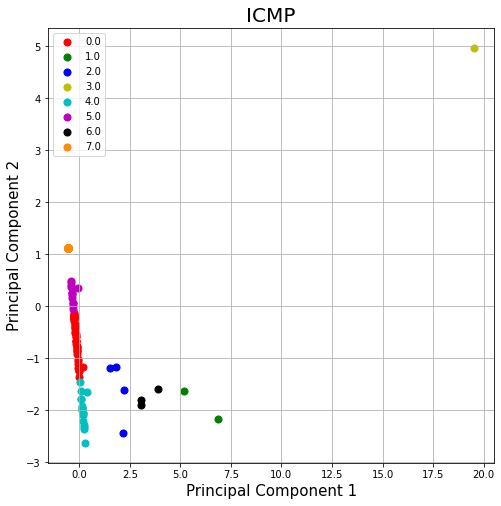

In [22]:
#print clusters
if icmp_window in icmp_parameters.keys():
  actual_param=icmp_parameters[icmp_window]
  print_clusters(rescaled_data_icmp[icmp_features], icmp_labels, actual_param.num_cluster, "ICMP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(rescaled_data_icmp[icmp_features], icmp_labels)

In [23]:
score_icmp = silhouette_score(rescaled_data_icmp[icmp_features], icmp_labels)
print(score_icmp)

0.6745591826400829


# Early Classification Performance

In [24]:
def set_original_labels(df_new, df_old, labels):
  df_new['cluster'] = labels
  cluster = []
  map_user = {}
  for index,row in df_new.iterrows():
    map_user[row['user']] = row['cluster']
  for index,row in df_old.iterrows():
    cluster.append(map_user[row['user']])
  cluster_np = np.asarray(cluster)
  cluster = cluster_np.reshape((cluster_np.size,1))
  rescaled_data = pd.DataFrame(StandardScaler().fit_transform(df_old), columns=df_old.columns)
  rescaled_data['cluster'] = cluster 

  return rescaled_data

##TCP (original data)

Score TCP:  -0.07057618645365446


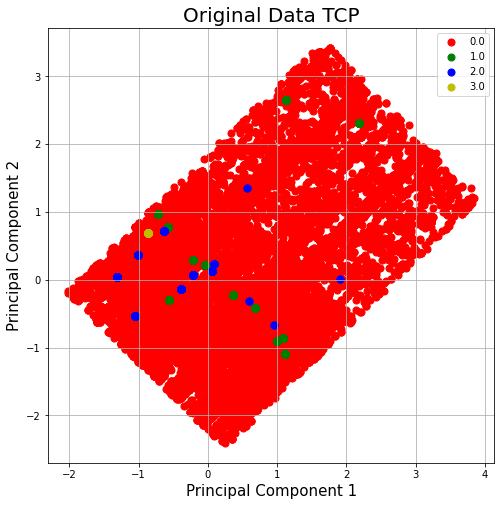

In [129]:
old_data_tcp = set_original_labels(data_tcp_rm, data_tcp_original, tcp_labels)

#old_tcp_features=[feature1, feature2, feature3, feature4, feature5, feature6, feature7]

old_tcp_features=[feature2, feature3 feature4, feature5]

#evaluating clustering perfomances
score_tcp = silhouette_score(old_data_tcp[old_tcp_features], old_data_tcp['cluster'])
print("Score TCP: ", score_tcp)

#print clusters TCP 
if tcp_window in tcp_parameters.keys():
  actual_param=tcp_parameters[tcp_window]
  print_clusters(old_data_tcp[old_tcp_features], old_data_tcp['cluster'], actual_param.num_cluster, "Original Data TCP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(old_data_tcp[old_tcp_features], old_data_tcp['cluster'])

##UDP (original data)

Score UDP:  0.22304377733618067


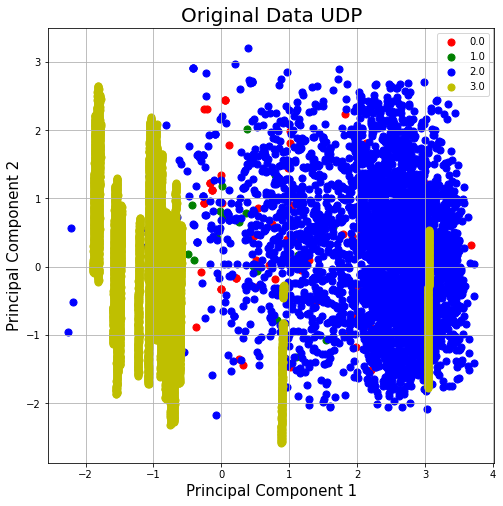

In [29]:
old_data_udp = set_original_labels(data_udp_rm, data_udp_original, udp_labels)

old_udp_features=[feature1, feature2, feature3, feature4, feature5, feature6]

#evaluating clustering perfomances 
score_udp = silhouette_score(old_data_udp[old_udp_features],old_data_udp['cluster'])
print("Score UDP: ", score_udp)

#print clusters UDP 
if udp_window in udp_parameters.keys():
  actual_param=udp_parameters[udp_window]
  print_clusters(old_data_udp[old_udp_features], old_data_udp['cluster'], actual_param.num_cluster, "Original Data UDP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(old_data_udp[old_udp_features], old_data_udp['cluster'])

##ICMP (original data)

Score ICMP:  0.22691581231801203


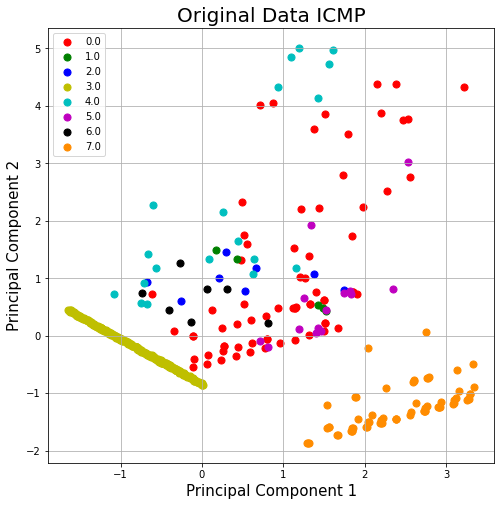

In [31]:
old_data_icmp = set_original_labels(data_icmp_rm, data_icmp_original, icmp_labels)

old_icmp_features=[feature1, feature2, feature4, feature6]

#evaluating clustering perfomances 
score_icmp = silhouette_score(old_data_icmp[old_icmp_features],old_data_icmp['cluster'])
print("Score ICMP: ",score_icmp)

#print clusters ICMP (old data)
if icmp_window in icmp_parameters.keys():
  actual_param=icmp_parameters[icmp_window]
  print_clusters(old_data_icmp[old_icmp_features],old_data_icmp['cluster'], actual_param.num_cluster, "Original Data ICMP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(old_data_icmp[old_icmp_features],old_data_icmp['cluster'])

##TCP (First port)

Score First Port TCP 0.7068213050787019



Score First Port TCP 0.7068213050787019





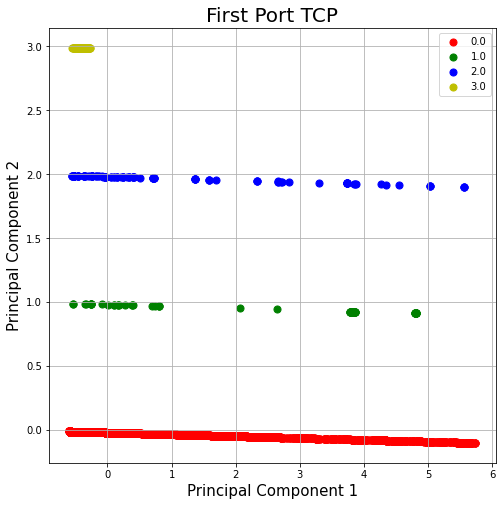

In [126]:
features=['first_port_scan', 'cluster']

score_tcp = silhouette_score(rescaled_data_tcp_rm[features],rescaled_data_tcp_rm['cluster'])
print("Score First Port TCP",score_tcp)
print("\n\n")

#print clusters 
if tcp_window in tcp_parameters.keys():
  actual_param=tcp_parameters[tcp_window]
  print_clusters(rescaled_data_tcp_rm[features],rescaled_data_tcp_rm['cluster'], actual_param.num_cluster, "First Port TCP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(rescaled_data_tcp_rm[features],rescaled_data_tcp_rm['cluster'])

In [123]:
rescaled_data_tcp_rm

,ts,src_ip,src_port,dst_ip,dst_port,pck_len,tcp_flags,user,num_attack,first_port_scan,ip_diff,port_diff,range_ip,range_port,ip_medium,ip_std,port_medium,port_std,pck_medium,pck_std,cluster
0,-1.643492,-1.572176,0.537285,0.467138,3.778369,-0.599495,-0.022479,-1.731984,10.802321,3.778369,10.668307,2.621456,6.447458,2.850478,0.416473,4.634392,4.139222,3.462036,-0.597155,-0.109865,1
1,-1.643411,0.114976,-0.091570,0.344926,0.024669,-0.599495,-0.022479,-1.731849,0.468279,0.024669,0.621991,-0.069287,3.031007,-0.094632,0.368729,3.265859,0.023554,-0.093847,-0.597155,-0.109865,0
2,-1.643353,-0.794223,1.052676,-0.238977,-0.267552,-0.599495,-0.022479,-1.731714,1.278792,-0.267552,1.602119,0.122909,4.632468,-0.094077,0.504716,4.244505,-0.270509,-0.093247,-0.597155,-0.109865,0
3,-1.643186,1.398121,-0.549092,1.634944,-0.589121,-0.599495,-0.022479,-1.731580,-0.139606,-0.589121,-0.113106,-0.069287,-0.225297,-0.094632,1.662847,-0.230752,-0.594022,-0.093847,-0.597155,-0.109865,0
4,-1.643075,-0.712835,-0.971234,1.648523,-0.583619,-0.599495,-0.022479,-1.731445,-0.139606,-0.583619,-0.113106,-0.069287,-0.225297,-0.094632,1.676656,-0.230752,-0.588485,-0.093847,-0.597155,-0.109865,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25734,1.803045,0.748483,-1.811351,0.969566,-0.589121,-0.599495,-0.022479,1.731445,-0.139606,-0.589121,-0.113106,-0.069287,-0.225297,-0.094632,0.986197,-0.230752,-0.594022,-0.093847,-0.597155,-0.109865,0
25735,1.803051,0.538781,0.765540,-1.488259,0.586908,-0.599495,-0.022479,1.731580,-0.139606,0.586908,-0.113106,-0.069287,-0.225297,-0.094632,-1.513266,-0.230752,0.589260,-0.093847,-0.597155,-0.109865,0
25736,1.803294,0.431730,-0.734893,-0.130344,1.357284,-0.599495,-0.022479,1.731714,-0.139606,1.357284,-0.113106,-0.069287,-0.225297,-0.094632,-0.132347,-0.230752,1.364387,-0.093847,-0.597155,-0.109865,0
25737,1.803337,-1.564110,-0.159105,1.064620,-0.583522,-0.599495,-0.022479,1.731849,-0.139606,-0.583522,-0.113106,-0.069287,-0.225297,-0.094632,1.082861,-0.230752,-0.588388,-0.093847,-0.597155,-0.109865,0


In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(df)
principalDf = pd.DataFrame(data = df, columns = ['first_port'])
labels_df = pd.DataFrame(labels, columns=['cluster']) 
final_df = pd.concat([principalDf, labels_df[['cluster']]], axis = 1)
final_df.dropna(inplace=True)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title(title, fontsize = 20)
targets = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'darkorange', 'darkblue', 'pink']
i=1
for target, color in zip(targets,colors):
    indicesToKeep = final_df['cluster'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'principal component 1']
              , final_df.loc[indicesToKeep, 'principal component 2']
              , c = color
              , s = 50)
    i=i+1
    if i>num_cluster:
      break
ax.legend(targets)
ax.grid()

In [120]:
rescaled_data_tcp_rm

,ts,src_ip,src_port,dst_ip,dst_port,pck_len,tcp_flags,user,num_attack,first_port_scan,ip_diff,port_diff,range_ip,range_port,ip_medium,ip_std,port_medium,port_std,pck_medium,pck_std,cluster
0,-1.643492,-1.572176,0.537285,0.467138,3.778369,-0.599495,-0.022479,-1.731984,10.802321,3.778369,10.668307,2.621456,6.447458,2.850478,0.416473,4.634392,4.139222,3.462036,-0.597155,-0.109865,1
1,-1.643411,0.114976,-0.091570,0.344926,0.024669,-0.599495,-0.022479,-1.731849,0.468279,0.024669,0.621991,-0.069287,3.031007,-0.094632,0.368729,3.265859,0.023554,-0.093847,-0.597155,-0.109865,0
2,-1.643353,-0.794223,1.052676,-0.238977,-0.267552,-0.599495,-0.022479,-1.731714,1.278792,-0.267552,1.602119,0.122909,4.632468,-0.094077,0.504716,4.244505,-0.270509,-0.093247,-0.597155,-0.109865,0
3,-1.643186,1.398121,-0.549092,1.634944,-0.589121,-0.599495,-0.022479,-1.731580,-0.139606,-0.589121,-0.113106,-0.069287,-0.225297,-0.094632,1.662847,-0.230752,-0.594022,-0.093847,-0.597155,-0.109865,0
4,-1.643075,-0.712835,-0.971234,1.648523,-0.583619,-0.599495,-0.022479,-1.731445,-0.139606,-0.583619,-0.113106,-0.069287,-0.225297,-0.094632,1.676656,-0.230752,-0.588485,-0.093847,-0.597155,-0.109865,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25734,1.803045,0.748483,-1.811351,0.969566,-0.589121,-0.599495,-0.022479,1.731445,-0.139606,-0.589121,-0.113106,-0.069287,-0.225297,-0.094632,0.986197,-0.230752,-0.594022,-0.093847,-0.597155,-0.109865,0
25735,1.803051,0.538781,0.765540,-1.488259,0.586908,-0.599495,-0.022479,1.731580,-0.139606,0.586908,-0.113106,-0.069287,-0.225297,-0.094632,-1.513266,-0.230752,0.589260,-0.093847,-0.597155,-0.109865,0
25736,1.803294,0.431730,-0.734893,-0.130344,1.357284,-0.599495,-0.022479,1.731714,-0.139606,1.357284,-0.113106,-0.069287,-0.225297,-0.094632,-0.132347,-0.230752,1.364387,-0.093847,-0.597155,-0.109865,0
25737,1.803337,-1.564110,-0.159105,1.064620,-0.583522,-0.599495,-0.022479,1.731849,-0.139606,-0.583522,-0.113106,-0.069287,-0.225297,-0.094632,1.082861,-0.230752,-0.588388,-0.093847,-0.597155,-0.109865,0


## UDP (First port)

Score First Port UDP 0.6250086803895009





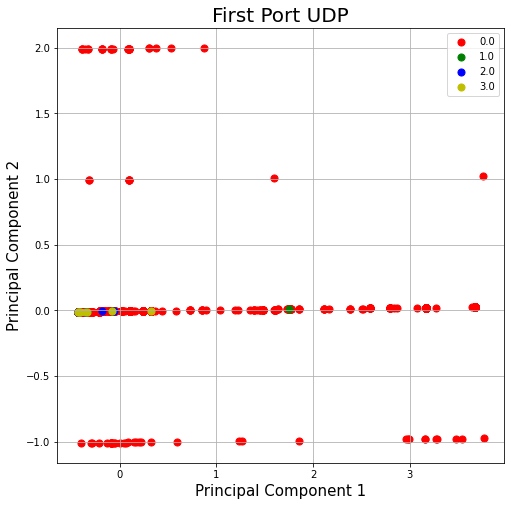

In [43]:
features=['first_port_scan', 'cluster']

#print clusters 
if udp_window in udp_parameters.keys():
  actual_param=udp_parameters[udp_window]
  print_clusters(rescaled_data_udp_rm[features], rescaled_data_tcp_rm['cluster'], actual_param.num_cluster, "First Port UDP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(rescaled_data_udp_rm[features], rescaled_data_tcp_rm['cluster'])

score_udp = silhouette_score(rescaled_data_udp_rm[features],rescaled_data_udp_rm['cluster'])
print("Score First Port UDP",score_udp)
print("\n\n")

##ICMP (src ip)

Score First Port UDP 0.4402030976328381





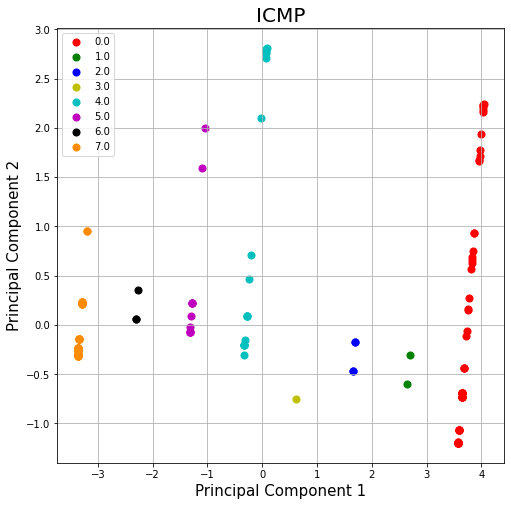

In [45]:
features=['src_ip', 'cluster']

#print clusters 
if icmp_window in icmp_parameters.keys():
  actual_param=icmp_parameters[icmp_window]
  print_clusters(rescaled_data_icmp[features], rescaled_data_icmp['cluster'], actual_param.num_cluster, "ICMP")
else:
  print("There are no algorithm optimizations for this time window. Default parameters are used")
  print_clusters(rescaled_data_icmp[features], rescaled_data_icmp['cluster'])

score_udp = silhouette_score(rescaled_data_icmp[features], rescaled_data_icmp['cluster'])
print("Score First Port UDP",score_udp)
print("\n\n")